In [9]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import phoebe

from elisa import (
    settings,
    BinarySystem,
    Observer
)

from visualization import (
    params_vs_speed, 
    params_vs_precision, 
    analyze_speed, 
    analyze_precision, 
    compare_models,
    produce_params_from_row
)

import matplotlib as mpl
import matplotlib.pyplot as plt

/home/data/projects/elisa_wrapper/venv36/lib/python3.6/site-packages/elisa/conf/settings.py:397: DeprecationWarning: Variable `atlas` in configuration section `support` is not longer supported and will be removed in future version.
Use atmosphere definition as initial parameter for given celestial object
  "for given celestial object", DeprecationWarning)


Default binary system:

In [3]:
binary_params = {
  "system": {
    "inclination": None,
    "period": None,
    "argument_of_periastron": None,
    "gamma": 0.0,
    "eccentricity": None,
    "primary_minimum_time": 0.0,
    "phase_shift": 0.0,
    "mass_ratio": None,
    "semi_major_axis": None
  },
  "primary": {
    "surface_potential": None,
    "synchronicity": 1.0,
    "t_eff": None,
    "metallicity": 0.0
  },
  "secondary": {
    "surface_potential": None,
    "synchronicity": 1.0,
    "t_eff": None,
    "metallicity": 0.0
  }
}

Obtaining phoebe system

In [4]:
def get_phoebe_binary(params, r_eq):
    b = phoebe.Bundle.default_binary()

    b.set_value("requiv@primary@component", r_eq[0])
    b.set_value("requiv@secondary@component", r_eq[1])
    b.set_value("teff@primary", params["primary"]["t_eff"] * u.K)
    b.set_value("teff@secondary", params["secondary"]["t_eff"] * u.K)
    b.set_value("abun@primary", params["primary"]["metallicity"])
    b.set_value("abun@secondary", params["secondary"]["metallicity"])
    b.set_value("syncpar@primary", params["primary"]["synchronicity"])
    b.set_value("syncpar@secondary", params['secondary']['synchronicity'])
    b.set_value("gravb_bol@primary", params['primary']['gravity_darkening'])
    b.set_value('gravb_bol@secondary', params['secondary']['gravity_darkening'])
    b.set_value('irrad_frac_refl_bol@primary', params['primary']['albedo'])
    b.set_value('irrad_frac_refl_bol@secondary', params['secondary']['albedo'])

    b.set_value('period@binary@component', params['system']['period'] * u.d)
    b.set_value("per0@binary@component", params['system']['argument_of_periastron'] * u.deg)
    b.set_value('ecc@binary@component', params['system']['eccentricity'])
    b.set_value('incl@binary@component', params['system']['inclination'] * u.deg)
    b.set_value("q@binary@component", params['system']['mass_ratio'])
    b.set_value('sma@binary@component', params['system']['semi_major_axis'] * u.solRad)

    b.set_value("irrad_method@phoebe01@phoebe@compute", "wilson")

    b.set_value('atm@primary', "ck2004")
    b.set_value('atm@secondary', "ck2004")

    b.set_value_all('ld_func_bol', value=settings.LIMB_DARKENING_LAW)
    # b.set_value_all('ld_mode_bol', value='manual')
    b.set_value_all('ld_coeffs_source_bol', value='ck2004')

    return b

Running a phoebe observations:

In [5]:
def run_phoebe_observation(binary, phases, passbands):
    times = phases * binary['period@orbit'].value
    passbands = [passbands] if type(passbands) == str else passbands
    for psbnd in passbands:
        binary.add_dataset('lc', times=times, passband=PASSBAND_DICT[psbnd], dataset=psbnd)
    binary.run_compute(irrad_method='wilson')
    # binary.run_compute()
    return binary

Sampling and subsequent comparison of models between ELISa and Phoebe:

In [28]:
datafile = os.path.join(os.getcwd(), "results", "samples.csv")
df = pd.read_csv(datafile)

old_datafile = os.path.join(os.getcwd(), "results", "samples_old_benchmark.csv")
old_df = pd.read_csv(old_datafile)

In [29]:
print(f"Number of samples: {df.shape[0]}")

Number of samples: 10000


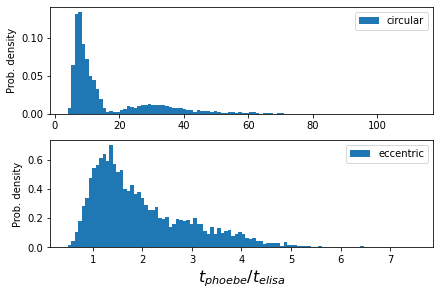

In [30]:
analyze_speed(df)

Benchmark comparison:

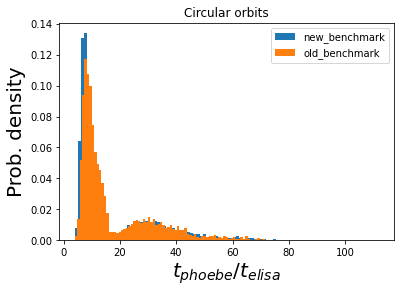

In [43]:
t_ratio = df['t_phoebe']/df['t_elisa']
eccentric = df['eccentricity'] != 0

plt.title("Circular orbits")
old_t_ratio = old_df['t_phoebe']/old_df['t_elisa']
old_eccentric = old_df['eccentricity'] != 0
plt.hist(t_ratio[~eccentric], bins=100, label="new_benchmark", density=True)
plt.hist(old_t_ratio[~old_eccentric], bins=100, label="old_benchmark", density=True)
plt.xlabel(r'$t_{phoebe}/t_{elisa}$', size=20)
plt.ylabel("Prob. density", size=20)
plt.legend()
plt.show()

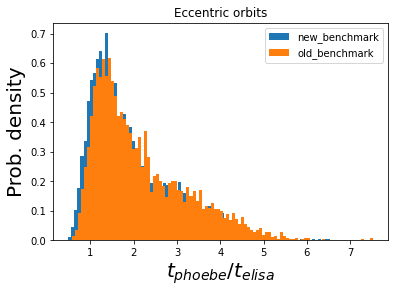

In [42]:
plt.title("Eccentric orbits")
plt.hist(t_ratio[eccentric], bins=100, label="new_benchmark", density=True)
plt.hist(old_t_ratio[old_eccentric], bins=100, label="old_benchmark", density=True)
plt.xlabel(r'$t_{phoebe}/t_{elisa}$', size=20)
plt.ylabel("Prob. density", size=20)
plt.legend()
plt.show()

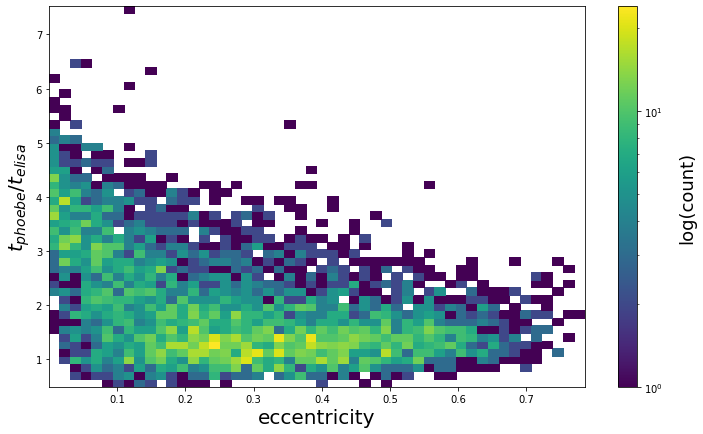

In [39]:


fig = plt.figure(figsize=(12, 7))
h = plt.hist2d(df['eccentricity'][eccentric], t_ratio[eccentric], bins=50, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel('eccentricity', size=20)
plt.ylabel(r'$t_{phoebe}/t_{elisa}$', size=20)
plt.show()

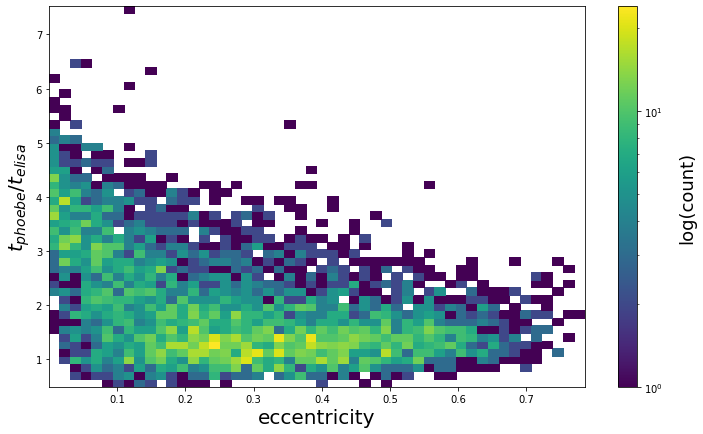

In [14]:
fig = plt.figure(figsize=(12, 7))
h = plt.hist2d(df['eccentricity'][eccentric], t_ratio[eccentric], bins=50, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel('eccentricity', size=20)
plt.ylabel(r'$t_{phoebe}/t_{elisa}$', size=20)
plt.show()

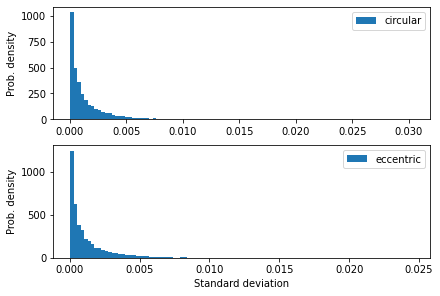

In [15]:
analyze_precision(df)

The highest discrepancy model:

2021-12-06 15:05:11,898 - 6524 - binary_system.system - INFO: initialising object BinarySystem
2021-12-06 15:05:11,982 - 6524 - binary_system.system - INFO: setting discretization factor of primary component to 8.00 according to discretization factor of the companion.
Discretization factors: (8.0, 7.0)
Number of triangles: (1280, 1588)
Radii: 1.76 solRad, 0.30 solRad solRad
2021-12-06 15:05:15,037 - 6524 - BUNDLE - WARNING: 'secondary' probably has a radiative atm (teff=9354K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
2021-12-06 15:05:15,038 - 6524 - BUNDLE - WARNING: 'secondary' probably has a radiative atm (teff=9354K>=8000K), for which irrad_frac_refl_bol>0.8 (suggestion: 1.0) might be a better approx than irrad_frac_refl_bol=0.60.
2021-12-06 15:05:15,140 - 6524 - BUNDLE - WARNING: 'secondary' probably has a radiative atm (teff=9354K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
2021-12-06 15:05:15,140 - 6524 - BUN

2021-12-06 15:05:17,989 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:18,074 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:18,148 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:18,267 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:18,333 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for 

2021-12-06 15:05:21,480 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:21,606 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:21,706 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:21,831 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:05:21,963 - 6524 - BUNDLE - WARNING: 'primary' probably has a convective atm (teff=3559K<=6600K), for 

100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


PHOEBE time: 25.02 s
2021-12-06 15:05:37,782 - 6524 - binary_system.system - INFO: initialising object BinarySystem
2021-12-06 15:05:37,815 - 6524 - binary_system.system - INFO: setting discretization factor of primary component to 8.00 according to discretization factor of the companion.
2021-12-06 15:05:37,817 - 6524 - observer.observer - INFO: initialising Observer instance
2021-12-06 15:05:37,840 - 6524 - observer.observer - INFO: observation is running
2021-12-06 15:05:38,416 - 6524 - observer.observer - INFO: observation finished
ELISA time: 0.64 s
Mean flux elisa: 0.9351136839108007, phoebe: 0.9508135059384577


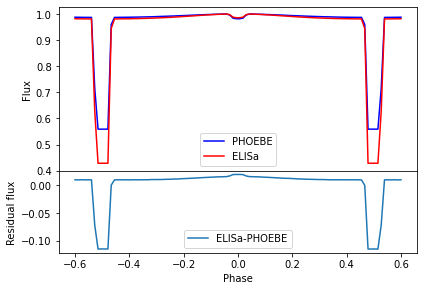

In [16]:
idd = df['max_dev'].idxmax()
compare_models(df, idd, 'TESS', n_phs=100)

Inverted model:

2021-12-06 15:08:02,405 - 6524 - binary_system.system - INFO: initialising object BinarySystem
2021-12-06 15:08:02,446 - 6524 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
Discretization factors: (7.0, 8.0)
Number of triangles: (1588, 1280)
Radii: 0.30 solRad, 1.76 solRad solRad
2021-12-06 15:08:04,567 - 6524 - BUNDLE - WARNING: 'primary' probably has a radiative atm (teff=9354K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
2021-12-06 15:08:04,567 - 6524 - BUNDLE - WARNING: 'primary' probably has a radiative atm (teff=9354K>=8000K), for which irrad_frac_refl_bol>0.8 (suggestion: 1.0) might be a better approx than irrad_frac_refl_bol=0.60.
2021-12-06 15:08:04,652 - 6524 - BUNDLE - WARNING: 'primary' probably has a radiative atm (teff=9354K>8000K), for which gravb_bol>=0.9 might be a better approx than gravb_bol=0.32.
2021-12-06 15:08:04,652 - 6524 - BUNDLE 

2021-12-06 15:08:07,268 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:07,331 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:07,442 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:07,588 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:07,672 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=66

2021-12-06 15:08:11,220 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:11,309 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:11,389 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:11,494 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=6600K), for which irrad_frac_refl_bol<0.75 (suggestion: 0.6) might be a better approx than irrad_frac_refl_bol=0.76.
2021-12-06 15:08:11,633 - 6524 - BUNDLE - WARNING: 'secondary' probably has a convective atm (teff=3559K<=66

100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


PHOEBE time: 22.84 s
2021-12-06 15:08:25,521 - 6524 - binary_system.system - INFO: initialising object BinarySystem
2021-12-06 15:08:25,540 - 6524 - binary_system.system - INFO: setting discretization factor of secondary component to 8.00 according to discretization factor of the companion.
2021-12-06 15:08:25,541 - 6524 - observer.observer - INFO: initialising Observer instance
2021-12-06 15:08:25,545 - 6524 - observer.observer - INFO: observation is running
2021-12-06 15:08:25,972 - 6524 - observer.observer - INFO: observation finished
ELISA time: 0.46 s
Mean flux elisa: 0.9638853945102993, phoebe: 0.9725304028816238


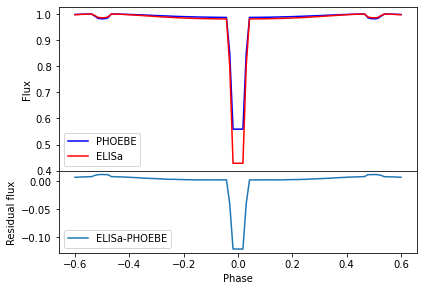

In [20]:
compare_models(df, idd, 'TESS', n_phs=100, invert_system=True)

In [17]:
print(df.iloc[idd])

inclination                 84.525293
period                       5.462220
argument_of_periastron      83.759521
eccentricity                 0.000000
mass_ratio                   0.220107
semi_major_axis              8.684924
p__surface_potential         5.165481
p__t_eff                  3558.633498
s__surface_potential         7.854065
s__t_eff                  9353.903760
std dev                      0.029101
max_dev                      0.131271
t_phoebe                   170.390000
t_elisa                      3.860000
N_phases                   494.000000
Name: 164, dtype: float64


2021-12-06 15:05:49,035 - 6524 - binary_system.system - INFO: initialising object BinarySystem
2021-12-06 15:05:49,084 - 6524 - binary_system.system - INFO: setting discretization factor of primary component to 8.00 according to discretization factor of the companion.
2021-12-06 15:05:49,244 - 6524 - observer.observer - INFO: initialising Observer instance


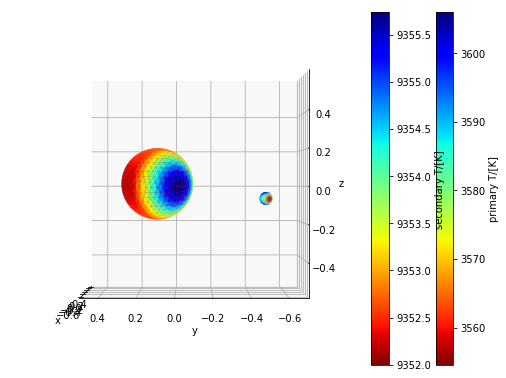

In [18]:
params = produce_params_from_row(df.iloc[idd])
system = BinarySystem.from_json(params)
system.plot.surface(phase=0.1, colormap='temperature')

The highest discrepancies correspond to models with primary t_eff below 10000 K.

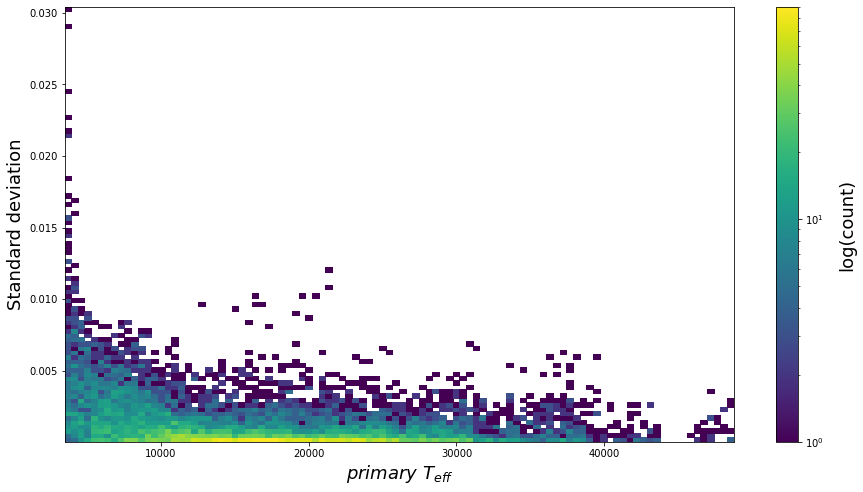

In [21]:
fig = plt.figure(figsize=(15, 8))
h = plt.hist2d(df["p__t_eff"], df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$primary~T_{eff}$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()

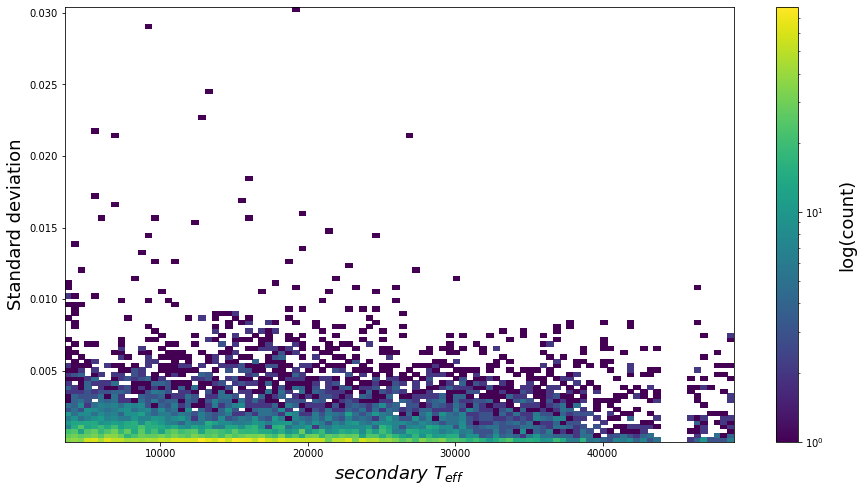

In [22]:
fig = plt.figure(figsize=(15, 8))
h = plt.hist2d(df["s__t_eff"], df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$secondary~T_{eff}$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()

Standard deviation as a function of temperature difference between the components:

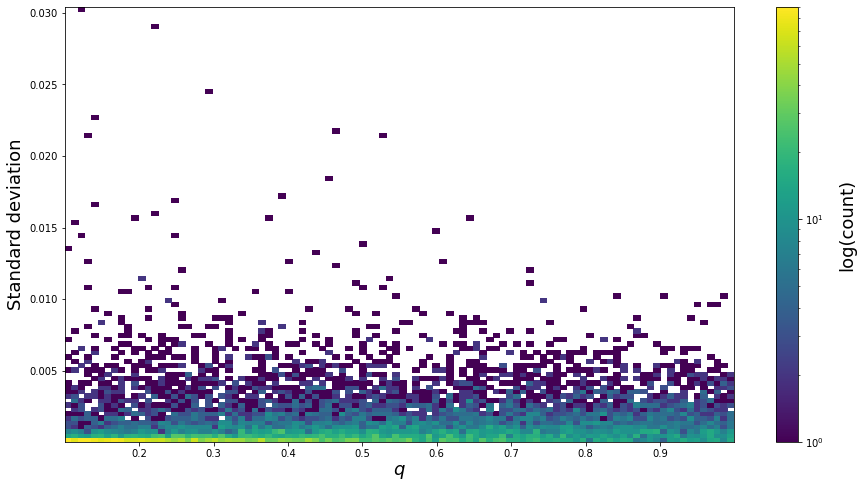

In [24]:
fig = plt.figure(figsize=(15, 8))
h = plt.hist2d(df["mass_ratio"], df["std dev"], bins=100, norm=mpl.colors.LogNorm())
cbar = fig.colorbar(h[3])
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('log(count)', rotation=90, size=18)
plt.xlabel(r'$q$',size=18)
plt.ylabel('Standard deviation', size=18)
plt.show()